In [2]:
# %% Library
######################################################################################
# print("Import Libraries & Set up directory")
import numpy as np
import pandas as pd
from Bio import SeqIO
import re
import os
from collections import defaultdict
from collections import Counter
import matplotlib.pyplot as plt
from statistics import mean, median, quantiles, mode

folder_path = "/Users/nguyjust/Library/CloudStorage/OneDrive-OregonHealth&ScienceUniversity/ubsite/"

### UniProt Reference File

Downloaded 5/21/2024 based on UniProt IDs from PSP database

In [3]:
# %% Read in UniProt Reference File
######################################################################################
## Data read in
fasta_seqs = list(SeqIO.parse(open(folder_path + 'data/idmapping_2024_05_21_psp.fasta'), 'fasta' ))

#print("Read in fasta file")

## Clean fasta ID names for quicker query
for ii in range(len(fasta_seqs)):
    fasta_seqs[ii].id = fasta_seqs[ii].id.split("|")[1] 
    
fasta_seq_df = pd.DataFrame(columns = ['id', 'seq'])

for ii in range(len(fasta_seqs)):
    fasta_seq_df.loc[len(fasta_seq_df.index)] = [fasta_seqs[ii].id, fasta_seqs[ii].seq]
    #fasta_seq_df.append({'id': fasta_seqs[0].id, 'seq': fasta_seqs[0].seq}, ignore_index=True)

fasta_seq_df['seq'] = fasta_seq_df['seq'].astype(str)

fasta_seq_list = fasta_seq_df.values.tolist()

In [4]:
## EDA on raw FASTA file
print(f"number of sequences: {len(fasta_seq_df)}")

print(f"FASTA original colummns: {fasta_seq_df.columns}")

number of sequences: 19754
FASTA original colummns: Index(['id', 'seq'], dtype='object')


### PhosphoSitePlus 

Website: 
https://www.phosphosite.org/staticDownloadshttps://www.phosphosite.org/staticDownloads

Downloaded: 
Ubiquitination_site_dataset.gz (2MB)

Last Modified: 
Fri May 17 09:42:44 EDT 2024

Date of Download: 
05/21/2024 09:58 PST

In [5]:
# %% PhosphoSitePlus Read in
######################################################################################

## Read in the PhosphoSite Dataset
data_psp = pd.read_csv(folder_path + '/raw_data/PSP/Ubiquitination_site_dataset',
                       sep="\t", low_memory=False, skiprows=[0, 1, 2])

## Look at the columns to check file integrity
print(f"PSP original colummns: {data_psp.columns}")

## Check by printing first row
print(data_psp.iloc[0])

## Check Number of entries in PSP
print(f'Number of entries in PSP: {len(data_psp)}')

PSP original colummns: Index(['GENE', 'PROTEIN', 'ACC_ID', 'HU_CHR_LOC', 'MOD_RSD', 'SITE_GRP_ID',
       'ORGANISM', 'MW_kD', 'DOMAIN', 'SITE_+/-7_AA', 'LT_LIT', 'MS_LIT',
       'MS_CST', 'CST_CAT#', 'Ambiguous_Site'],
      dtype='object')
GENE                        YWHAB
PROTEIN               14-3-3 beta
ACC_ID                     P31946
HU_CHR_LOC               20q13.12
MOD_RSD                     K5-ub
SITE_GRP_ID              41481400
ORGANISM                    human
MW_kD                       28.08
DOMAIN                        NaN
SITE_+/-7_AA      ___MtMDksELVQkA
LT_LIT                        NaN
MS_LIT                        4.0
MS_CST                        NaN
CST_CAT#                      NaN
Ambiguous_Site                  0
Name: 0, dtype: object
Number of entries in PSP: 126329


In [6]:
ambig_psp = data_psp[data_psp['Ambiguous_Site'] == 1]

ambig_psp.head()

print(f"Number of ambiguous sites: {len(ambig_psp)}")

Number of ambiguous sites: 9943


*Consideration:*

Why are there ambiguous sites? Where does this data come from? Should I filter these out of the training data?

In [7]:
## Check PSP df column names
## Data with selected data columns
## PROTEIN, ACC_ID, ORGANISM, MOD_RSD, SITE_+/-7_AA
data_sel_psp = data_psp[['PROTEIN', 'ACC_ID',
                         'ORGANISM', 'MOD_RSD', 'SITE_+/-7_AA']].copy()

## Check that correct columns is copied
data_sel_psp.head()

,PROTEIN,ACC_ID,ORGANISM,MOD_RSD,SITE_+/-7_AA
0,14-3-3 beta,P31946,human,K5-ub,___MtMDksELVQkA
1,14-3-3 beta,P31946,human,K11-ub,DksELVQkAkLAEQA
2,14-3-3 beta,Q9CQV8,mouse,K11-ub,DksELVQkAkLAEQA
3,14-3-3 beta,P35213,rat,K11-ub,DkSELVQkAkLAEQA
4,14-3-3 beta,P31946,human,K13-ub,sELVQkAkLAEQAER


In [8]:
## Clean Ub location column
## ie: originally Kxx-ub, but just need to capture the location number for the modified site
data_sel_psp['ub_mod_loc'] = data_sel_psp.MOD_RSD.str.extract('(\d+)')
## Drop the old modified site column
data_sel_psp = data_sel_psp.drop(['MOD_RSD'], axis=1)

## Check that only numbers were captured in the location
data_sel_psp.head()

,PROTEIN,ACC_ID,ORGANISM,SITE_+/-7_AA,ub_mod_loc
0,14-3-3 beta,P31946,human,___MtMDksELVQkA,5
1,14-3-3 beta,P31946,human,DksELVQkAkLAEQA,11
2,14-3-3 beta,Q9CQV8,mouse,DksELVQkAkLAEQA,11
3,14-3-3 beta,P35213,rat,DkSELVQkAkLAEQA,11
4,14-3-3 beta,P31946,human,sELVQkAkLAEQAER,13


In [9]:
## Renaming column names
data_sel_psp = data_sel_psp.rename(columns={"PROTEIN": "protein",
                           "ACC_ID": "uniprot_id", 
                           "ORGANISM": "organism",
                           "SITE_+/-7_AA" : "sequence"})
data_sel_psp['sequence'] = data_sel_psp['sequence'].str.upper()

data_sel_psp.head()

,protein,uniprot_id,organism,sequence,ub_mod_loc
0,14-3-3 beta,P31946,human,___MTMDKSELVQKA,5
1,14-3-3 beta,P31946,human,DKSELVQKAKLAEQA,11
2,14-3-3 beta,Q9CQV8,mouse,DKSELVQKAKLAEQA,11
3,14-3-3 beta,P35213,rat,DKSELVQKAKLAEQA,11
4,14-3-3 beta,P31946,human,SELVQKAKLAEQAER,13


In [10]:
## PSP organism EDA
## Look at the unique species
print(set(data_sel_psp['organism']))

## Number of unique species
print(f"Number of unique species in PSP: {len(set(data_sel_psp['organism']))}")

{'rat', 'pig', 'cow', 'SARSCoV1', 'duck', 'mouse', 'human', 'SARSCoV2', 'chicken'}
Number of unique species in PSP: 9


** trying to clean up species name to scientific to match other databases, but can do later

mouse - Mus musculus

chicken - Gallus gallus

SARSCoV2 - 

cow - Bos taurus

SARSCoV1 - 

duck - Anas platyrhynchos

pig - Sus scrofa

human - Homo sapiens

rat - Rattus norvegicus

In [11]:
len_psp = len(data_sel_psp['uniprot_id'])
psp_uniprot_unique = list(set(data_sel_psp["uniprot_id"]))

print(f'Total PSP observations: {len_psp}')
print(f"Total unique PSP proteins: {len(psp_uniprot_unique)}")

Total PSP observations: 126329
Total unique PSP proteins: 19917


In [12]:
## Save UniProt IDs to file to download full information from UniProt
np.savetxt(folder_path + "data/psp_uniprot_ids.tsv",
           psp_uniprot_unique,
           delimiter="\t",
           fmt='% s')

In [13]:
## Check to see if fragment centers on K

## Create list of lists to keep track of whether sites are K or not
psp_non_k = list()
psp_non_k_index = list()

## Check to see that the fragment contains a lysine
for ii in range(len(data_sel_psp)):
    if data_sel_psp['sequence'][ii][7] == "K":
        #psp_k.append(data_sel_psp.values.tolist()[ii])
        pass
    else:
        psp_non_k_index.append(ii)
        #print(data_sel_psp['sequence'][ii])
        
        ## Print out which amino acid is ubiquitinated if NOT K
        print(data_sel_psp['sequence'][ii][7])
        
        psp_non_k.append(data_sel_psp.values.tolist()[ii])
        #psp_non_k.append(data_sel_psp)

## Create dataframe
psp_non_k = pd.DataFrame(psp_non_k, 
                         columns =['protein', 'uniprot_id', 'organism', 'sequence', 'ub_mod_loc'])

S
R
T
N
R
S
T
S
C
C
S
S
T


In [14]:
## Get df where only mod on K
print(f'Sites not on a lysine: {len(psp_non_k)}')

print(len(data_sel_psp))
print(len(psp_non_k_index))
psp_k = data_sel_psp.drop(psp_non_k_index)
print(len(psp_k))

Sites not on a lysine: 13
126329
13
126316


In [15]:
## Check to see if fragment matches reference protein sequence

## Create list of lists to keep track of whether sites are matched in the reference FASTA
psp_non_match = list()
psp_non_match_index = list()

# Check to see that the fragment contains a lysine
for ii in range(len(psp_k)):
    try:
        ## Grab row where matches uniprot id
        fasta_data = fasta_seq_df.loc[fasta_seq_df['id']
                                      == psp_k['uniprot_id'][ii]]
        ## Keep only letters in the fragment recorded
        s = re.sub('[^a-zA-Z]+', '', str(psp_k['sequence'][ii]))
        if s in str(fasta_data.iloc[0]['seq']):
            pass
        else:
            psp_non_match.append(psp_k.values.tolist()[ii])
            psp_non_match_index.append(ii)
    except:
        pass

In [16]:
## Look at non-match PSP seqs
psp_non_match


[['ARIH1', 'D3ZXL1', 'rat', 'ENWHDPVKCKWLKKW', '314'],
 ['ARIH1', 'D3ZXL1', 'rat', 'WHDPVKCKWLKKWIK', '316'],
 ['CMIP', 'F1M8D3', 'rat', 'HPRTFLSKILTSKFL', '74'],
 ['H2B1K', 'O60814', 'human', 'VTKYTSAK_______', '125']]

In [17]:
# Get df where fragments match
print(len(psp_k))
print(len(psp_non_match_index))
psp_k_match = psp_k.drop(psp_non_match_index).reset_index()
print(len(psp_k_match))

126316
4
126312


In [18]:
## Check site to the reference sequence that it is a lysine

## Create lists for ids/seqs of the fasta to loop through faster with indexing
ids = [ii[0] for ii in fasta_seq_list]
seqs = [ii[1] for ii in fasta_seq_list]

no_ref_match = list()
# Check to see that the fragment contains a lysine
for ii in range(len(psp_k_match)):
    #print(ii)
    try:
        tmp_idx_seq = ids.index(psp_k_match['uniprot_id'][ii])
        temp_seq = seqs[tmp_idx_seq]
        site = temp_seq[[int(psp_k_match['ub_mod_loc'][ii])-1]]
        if site == "K":
            pass
        else:
            no_ref_match.append(ii)
    except:
        pass
    

In [19]:
no_ref_match

[]

In [20]:
psp_k_match.head()
# %%
# Write out master info
psp_k_match.to_csv(
     folder_path + '/data/psp_info.tsv', sep='\t', index=False)



In [21]:
# Quick EDA

print(f"Number of unique sites: {len(psp_k_match['ub_mod_loc'])}")

print(f"Number of unique proteins: {len(set(psp_k_match['uniprot_id']))}")

print(f"Number of unique organisms: {len(set(psp_k_match['organism']))}")

Number of unique sites: 126312
Number of unique proteins: 19916
Number of unique organisms: 9


In [ ]:

print(f'mean: {mean(psp_site_count_sort.values())}')
print(f'median: {median(psp_site_count_sort.values())}')
print(f'mode: {mode(psp_site_count_sort.values())}')
print(f'quantiles: {quantiles(psp_site_count_sort.values())}')

### EDA on Ub/Lysine proportions

In [26]:
psp_site_count = Counter(psp_k_match['uniprot_id'])
psp_site_count_sort = dict(sorted(psp_site_count.items(), key=lambda item: item[1], reverse=True))
list(psp_site_count_sort.items())[:4]
#max_y_lim = 475
#plt.bar(psp_site_count_sort.keys(), psp_site_count_sort.values())

[('Q09666', 463), ('A2ASS6', 333), ('P78527', 198), ('P46013', 174)]

In [63]:
psp_norm_lys_count = pd.DataFrame(psp_site_count.items(), columns=['protein', 'ub_sites'])
psp_norm_lys_count[["len_seq", "k_count"]] = None
psp_norm_lys_count.head()

,protein,ub_sites,len_seq,k_count
0,P31946,16,None,None
1,Q9CQV8,11,None,None
2,P35213,7,None,None
3,P62258,15,None,None
4,P62259,14,None,None


In [64]:
for ii in range(len(psp_norm_lys_count)):
    try:
        tmp_idx_seq = ids.index(psp_norm_lys_count['protein'][ii])
        temp_seq = seqs[tmp_idx_seq]
        psp_norm_lys_count['len_seq'][ii] = len(temp_seq)
        psp_norm_lys_count['k_count'][ii] = temp_seq.count('K')
    except:
        pass

/var/folders/cv/hy97rgx16wj00q34_wgkvv4jlf3s4z/T/ipykernel_3375/625857690.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  psp_norm_lys_count['len_seq'][ii] = len(temp_seq)
/var/folders/cv/hy97rgx16wj00q34_wgkvv4jlf3s4z/T/ipykernel_3375/625857690.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  psp_norm_lys_count['k_count'][ii] = temp_seq.count('K')


In [65]:
psp_norm_lys_count['ub_seq_prop'] = psp_norm_lys_count['ub_sites'] / psp_norm_lys_count['len_seq'] *100
psp_norm_lys_count['ub_lys_prop'] = psp_norm_lys_count['ub_sites'] / psp_norm_lys_count['k_count'] *100
psp_norm_lys_count['lys_seq_prop'] = psp_norm_lys_count['k_count'] / psp_norm_lys_count['len_seq'] * 100
psp_norm_lys_count.dropna(inplace=True)

In [69]:
psp_norm_lys_count.sort_values(by=['ub_seq_prop'], ascending=False).head()

,protein,ub_sites,len_seq,k_count,ub_seq_prop,ub_lys_prop,lys_seq_prop
7120,P16403,34,213,59,15.962441,57.627119,27.699531
17485,P63313,6,44,8,13.636364,75.0,18.181818
17487,P62328,6,44,9,13.636364,66.666667,20.454545
17645,P58771,36,284,39,12.676056,92.307692,13.732394
3434,P23528,21,166,25,12.650602,84.0,15.060241


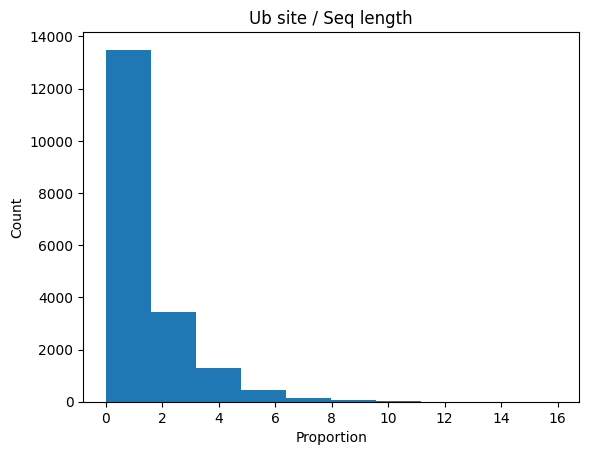

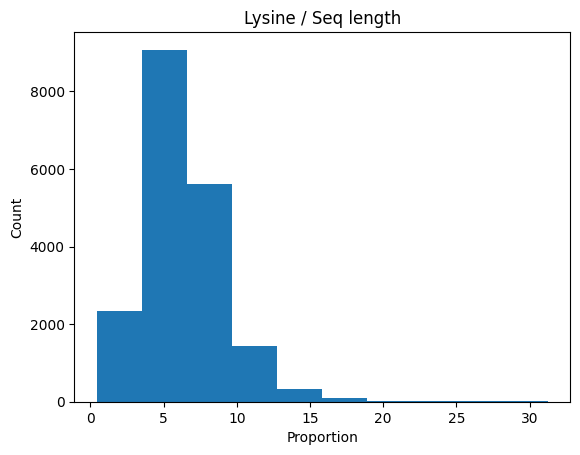

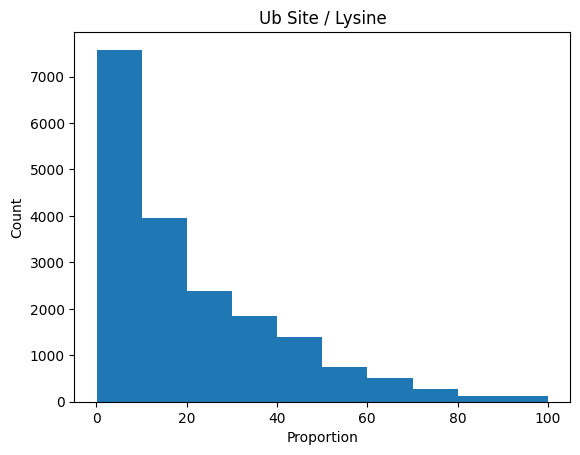

In [113]:
plt.hist(psp_norm_lys_count['ub_seq_prop'])
plt.title("Ub site / Seq length")
plt.xlabel("Proportion")
plt.ylabel("Count")

plt.show()

plt.hist(psp_norm_lys_count['lys_seq_prop'])
plt.title("Lysine / Seq length")
plt.xlabel("Proportion")
plt.ylabel("Count")
plt.show()

plt.hist(psp_norm_lys_count['ub_lys_prop'])
plt.title("Ub Site / Lysine")
plt.xlabel("Proportion")
plt.ylabel("Count")
plt.show()

In [114]:
ub_seq_prop_count = Counter(psp_norm_lys_count['ub_seq_prop'])
ub_lys_prop_count = Counter(psp_norm_lys_count['ub_lys_prop'])
lys_seq_prop_count = Counter(psp_norm_lys_count['lys_seq_prop'])

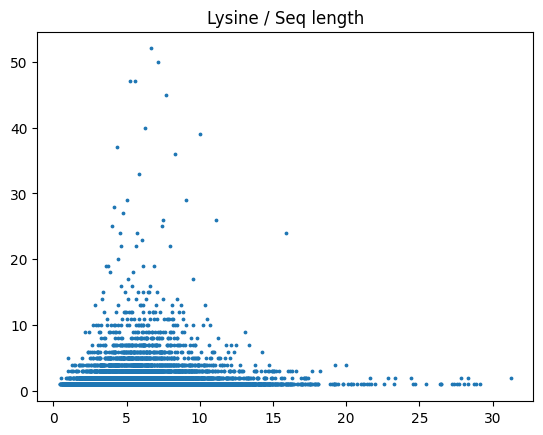

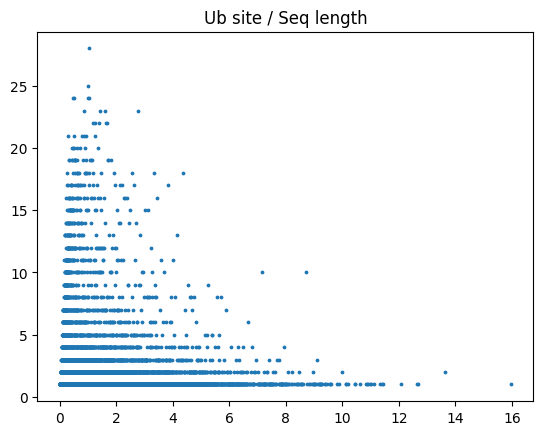

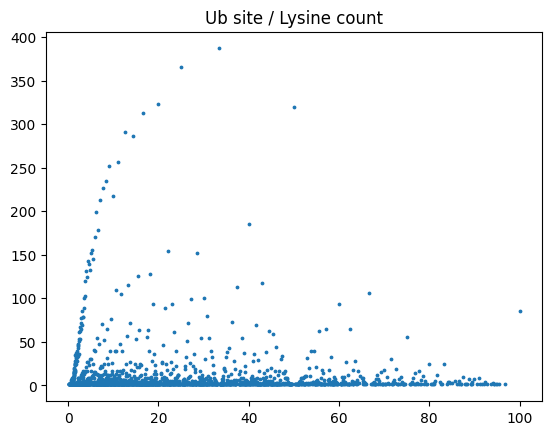

In [109]:

plt.scatter([x[0] for x in lys_seq_prop_count.items()],
            [x[1]for x in lys_seq_prop_count.items()], 
            s=3)
plt.title("Lysine / Seq length")
plt.show()

plt.scatter([x[0] for x in ub_seq_prop_count.items()],
            [x[1] for x in ub_seq_prop_count.items()],
            s=3)
plt.title("Ub site / Seq length")
plt.show()

plt.scatter([x[0] for x in ub_lys_prop_count.items()],
            [x[1]for x in ub_lys_prop_count.items()],
            s=3)
plt.title("Ub site / Lysine count")
plt.show()

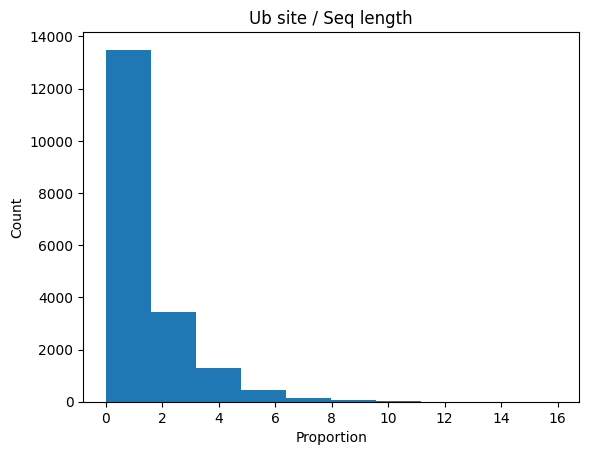

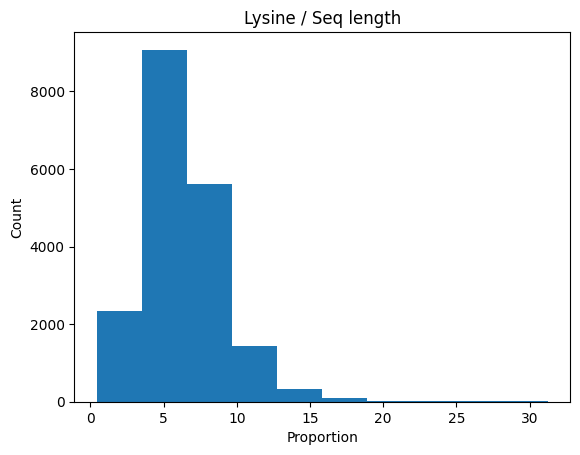

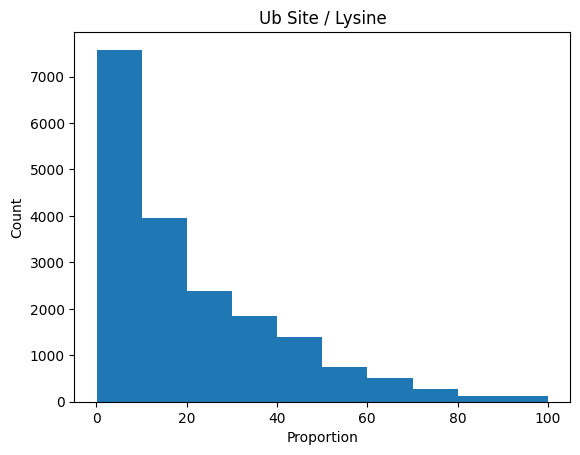